# Hamiltonian simulation with Gray code encoding - Vigo noise model, with measurement error mitigation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.ignis.verification import tomography

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})

import qutip as qt

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from device import Device

In [2]:
# Perform unitary evolution 
def unitary_evolution(ham, t):
    return expm(-1j * ham * t)

states_gc = ['00', '10', '11', '01']
states_jw = ['1000', '0100', '0010', '0001']

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

backend = Aer.get_backend('qasm_simulator')

## Simulation

In [3]:
# Arbitrary simulation time
T = 1

# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 100

In [4]:
# Get the matrix in "qiskit order"
H_gc = DenseEncodingHamiltonian(N_states=4)
gc_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_gc.pauli_coeffs.items()])


uniform_superposition_gc = 0.5 * np.array([[1], [1], [1], [1]])
exact_wavefunction_gc = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc

# Set the IBM Q device noise model
device = Device('ibmq_vigo', mitigate_meas_error=True, N_qubits=H_gc.N_qubits)

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_2qubits.pkl


This code loops over the different numbers of Trotter steps and performs the evolution by running the circuit using the statevector simulator.

In [5]:
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_gc.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

trace_dists_gc = np.zeros(max_trotter_steps)

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
    q = QuantumRegister(H_gc.N_qubits)
    
    circuit = QuantumCircuit(q)
    
    circuit.h(q)
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
        
    ######################
    #     Tomography     #
    ######################
    tomography_circuits = tomography.state_tomography_circuits(circuit, q)

    tomo_job = execute(tomography_circuits, 
                       backend=backend, 
                       shots=10000,
                       coupling_map = device.coupling_map,
                       noise_model = device.noise_model,
                       basis_gates = device.noise_model.basis_gates,
                       initial_layout = device.layout)
    
    tomo_results = tomo_job.result()
    
    # Do measurement error mitigation
    tomo_results = device.meas_filter.apply(tomo_results)
    
    fitter = tomography.StateTomographyFitter(tomo_results, tomography_circuits)
    density_mat = fitter.fit()
    
    trace_dists_gc[n_trotter_steps-1] = qt.tracedist(qt.Qobj(exact_wavefunction_gc), qt.Qobj(density_mat))

  0%|          | 0/100 [00:00<?, ?it/s]/home/olivia/Software/anaconda3/envs/deuteron/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/olivia/Software/anaconda3/envs/deuteron/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STA

Text(0.5, 1.0, 'Gray code, N=4, Hamiltonian evolution time t = 1')

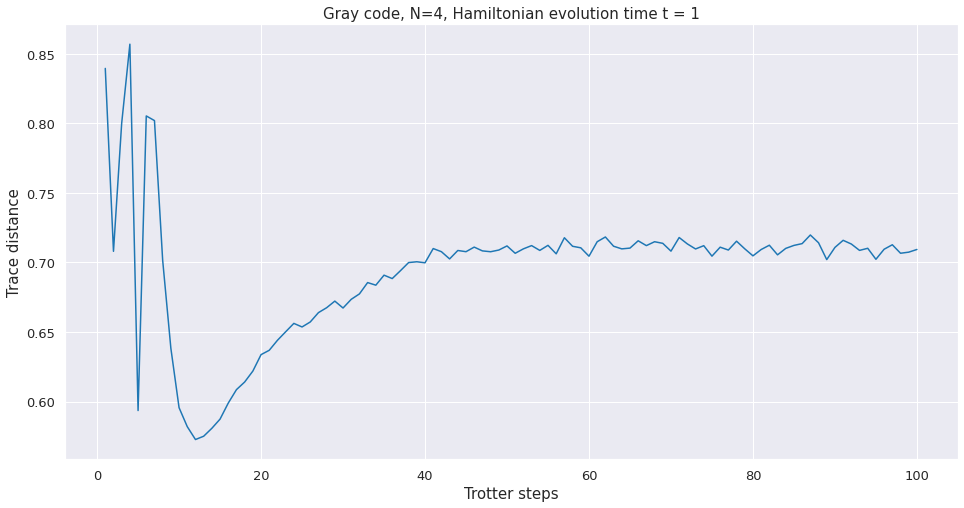

In [6]:
plt.plot(range(min_trotter_steps, max_trotter_steps+1), trace_dists_gc, color='tab:blue')
plt.xlabel("Trotter steps", fontsize=15)
plt.ylabel("Trace distance", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title(f"Gray code, N=4, Hamiltonian evolution time t = {T}", fontsize=15)
#plt.savefig("gc-trotter-probs.pdf")

Now we'll do the same thing for Jordan-Wigner. We'll prepare the uniform superposition here by running the variational ansatz with the set of parameters that will produce it.

In [7]:
H_jw = SparseEncodingHamiltonian(N_states=4)
jw_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_jw.pauli_coeffs.items()])
uniform_jw = 0.5 * np.array([[0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0]]).reshape((16, 1))

device = Device('ibmq_vigo', True, H_jw.N_qubits)

exact_wavefunction_jw = unitary_evolution(jw_ham_rep, t=T) @ uniform_jw

Calibration file found; reading calibration data from device_ibmq_vigo_calibration_4qubits.pkl


In [8]:
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_jw.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

results_dict_jw = {x : np.zeros(max_trotter_steps) for x in states_jw}

trace_dists_jw = np.zeros(max_trotter_steps)

# To prepare the uniform superposition, run the sparse variational ansatz with the following parameters
θ_1 = 2 * np.pi / 3
θ_2 = 2 * np.arccos(1/np.sqrt(3)) 
θ_3 = 2 * np.arccos(1/(np.sqrt(3) * np.sin(θ_2 / 2)))
params = [θ_1, θ_2, θ_3]

# Hang on to the gate counts of the decomposed circuits
gate_counts_jw = np.zeros((max_trotter_steps, 3))

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
    # Construct uniform superposition over spherical coordinates
    q = QuantumRegister(H_jw.N_qubits)
    
    circuit = QuantumCircuit(q)
    circuit.x(q[0])
    circuit.ry(θ_1, q[1])
    circuit.cx(q[1], q[0])
    circuit.cry(θ_2, q[1], q[2])
    circuit.cx(q[2], q[1])
    circuit.cry(θ_3, q[2], q[3])
    circuit.cx(q[3], q[2])
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
    ######################
    #     Tomography     #
    ######################
    tomography_circuits = tomography.state_tomography_circuits(circuit, q)

    tomo_job = execute(tomography_circuits, 
                       backend=backend, 
                       shots=10000,
                       coupling_map = device.coupling_map,
                       noise_model = device.noise_model,
                       basis_gates = device.noise_model.basis_gates,
                       initial_layout = device.layout)
    
    tomo_results = tomo_job.result()
    
    # Do measurement error mitigation
    tomo_results = device.meas_filter.apply(tomo_results)
    
    fitter = tomography.StateTomographyFitter(tomo_results, tomography_circuits)
    density_mat = fitter.fit()
    
    trace_dists_jw[n_trotter_steps-1] = qt.tracedist(qt.Qobj(exact_wavefunction_jw), qt.Qobj(density_mat))

  0%|          | 0/100 [00:00<?, ?it/s]/home/olivia/Software/anaconda3/envs/deuteron/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/olivia/Software/anaconda3/envs/deuteron/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STA

Text(0.5, 1.0, 'Jordan-Wigner, N=4, Hamiltonian evolution time t = 1')

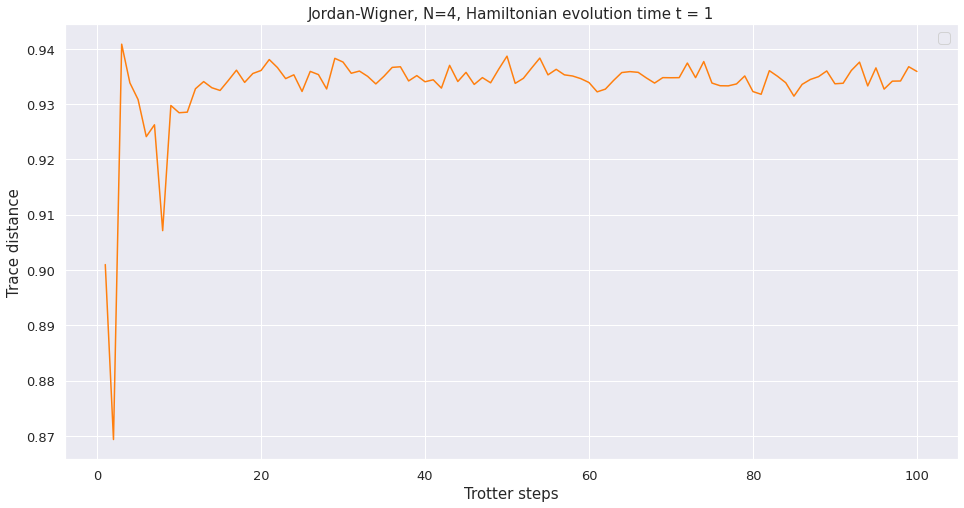

In [9]:
plt.plot(range(min_trotter_steps, max_trotter_steps+1), trace_dists_jw, color='tab:orange')
plt.xlabel("Trotter steps", fontsize=15)
plt.ylabel("Trace distance", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.title(f"Jordan-Wigner, N=4, Hamiltonian evolution time t = {T}", fontsize=15)

Let's plot it all together...

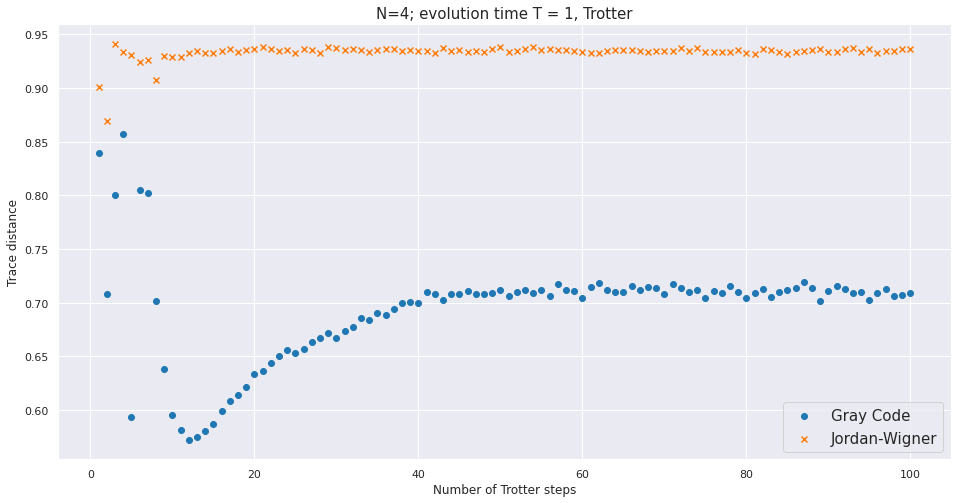

In [10]:
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), trace_dists_gc, color='tab:blue', label = "Gray Code")
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), trace_dists_jw, color='tab:orange', marker='x', label = "Jordan-Wigner")
plt.xlabel("Number of Trotter steps")
plt.ylabel("Trace distance")
plt.legend(fontsize=15)
plt.title(f"N=4; evolution time T = {T}, Trotter", fontsize=15);
#plt.savefig("gc-trotter-probs.pdf")

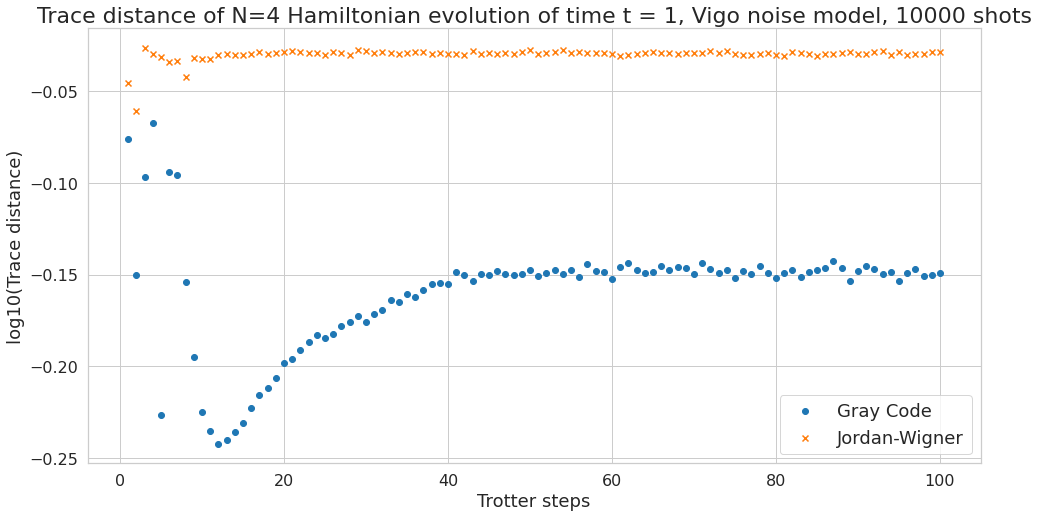

In [12]:
sns.set(rc={'figure.figsize':(16,8)})
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style('whitegrid')

plt.scatter(range(min_trotter_steps, max_trotter_steps+1), np.log10(trace_dists_gc), color='tab:blue', label = "Gray Code")
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), np.log10(trace_dists_jw), color='tab:orange', marker='x', label = "Jordan-Wigner")
plt.xlabel("Trotter steps", fontsize=18)
plt.ylabel("log10(Trace distance)", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(f"Trace distance of N=4 Hamiltonian evolution of time t = {T}, Vigo noise model, 10000 shots", fontsize=22);
plt.savefig("paper-figures/fig10b-hamsim-noise-tracedist-mitmeas.pdf")

## Explaining the dip in trace distance

When looking at the above plot, we can see that the trace distance gets better up to a point, but then starts to increase again. My suspicion is that this inflection point corresponds roughly to where the execution time of the circuit surpasses the coherence time of the qubits.

So, let's make a very rough estimate of this execution time and see how close we get.

In [13]:
# Trotter steps, SQ gates, CNOTs, Depth
# Just lifted from the statevector simulator gate counts
circuit_data_gc = [[1, 17.0, 6.0, 20.0],
                    [2, 32.0, 12.0, 39.0],
                    [3, 47.0, 18.0, 58.0],
                    [4, 62.0, 24.0, 77.0],
                    [5, 77.0, 30.0, 96.0],
                    [6, 92.0, 36.0, 115.0],
                    [7, 107.0, 42.0, 134.0],
                    [8, 122.0, 48.0, 153.0],
                    [9, 137.0, 54.0, 172.0],
                    [10, 152.0, 60.0, 191.0],
                    [11, 167.0, 66.0, 210.0],
                    [12, 182.0, 72.0, 229.0],
                    [13, 197.0, 78.0, 248.0],
                    [14, 212.0, 84.0, 267.0],
                    [15, 227.0, 90.0, 286.0],
                    [16, 242.0, 96.0, 305.0],
                    [17, 257.0, 102.0, 324.0],
                    [18, 272.0, 108.0, 343.0],
                    [19, 287.0, 114.0, 362.0],
                    [20, 302.0, 120.0, 381.0],
                    [21, 317.0, 126.0, 400.0],
                    [22, 332.0, 132.0, 419.0],
                    [23, 347.0, 138.0, 438.0],
                    [24, 362.0, 144.0, 457.0],
                    [25, 377.0, 150.0, 476.0],
                    [26, 392.0, 156.0, 495.0],
                    [27, 407.0, 162.0, 514.0],
                    [28, 422.0, 168.0, 533.0],
                    [29, 437.0, 174.0, 552.0]]


Let's load up some data from Vigo - this is pulled recently, and assumes that the qubits in use are 0 and 1 (which should be the case since we didn't specify a layout).

In [14]:
from qiskit import IBMQ

provider = IBMQ.load_account()
provider.backends()

# get device information 
device = provider.get_backend('ibmq_vigo')
properties = device.properties()

Execution time of the CNOT gate between qubits 0 and 1.

In [15]:
properties.gates[-8:-6]

[namespace(qubits=[0, 1],
           gate='cx',
           parameters=[Nduv(datetime.datetime(2020, 8, 9, 6, 15, 13, tzinfo=tzutc()), gate_error, , 0.0090516055381267),
                       Nduv(datetime.datetime(2020, 8, 9, 6, 38, 5, tzinfo=tzutc()), gate_length, ns, 348.4444444444444)],
           name='cx0_1'),
 namespace(qubits=[1, 0],
           gate='cx',
           parameters=[Nduv(datetime.datetime(2020, 8, 9, 6, 15, 13, tzinfo=tzutc()), gate_error, , 0.0090516055381267),
                       Nduv(datetime.datetime(2020, 8, 9, 6, 38, 5, tzinfo=tzutc()), gate_length, ns, 384)],
           name='cx1_0')]

In [16]:
mean_gate_length = (348.44e-9 + 384e-9) / 2

Grab the coherence times of the two qubits.

In [41]:
# These are the coherence times for the qubits on the data the noise model was pulled
# The gate operation times don't seem to change much, but coherence times do
qubit0_t2 = 17.14151362421807e-6
qubit1_t2 = 111.42172460237252e-6
mean_t2 = (qubit0_t2 + qubit1_t2) / 2

Single qubit gate execution time - just assume everything is a u3.

In [42]:
properties.gates[3]

namespace(qubits=[0],
          gate='u3',
          parameters=[Nduv(datetime.datetime(2020, 8, 9, 6, 10, 12, tzinfo=tzutc()), gate_error, , 0.0006896990595236518),
                      Nduv(datetime.datetime(2020, 8, 9, 6, 38, 5, tzinfo=tzutc()), gate_length, ns, 71.11111111111111)],
          name='u3_0')

In [43]:
properties.gates[7]

namespace(qubits=[1],
          gate='u3',
          parameters=[Nduv(datetime.datetime(2020, 8, 9, 6, 10, 12, tzinfo=tzutc()), gate_error, , 0.0010178489338030783),
                      Nduv(datetime.datetime(2020, 8, 9, 6, 38, 5, tzinfo=tzutc()), gate_length, ns, 71.11111111111111)],
          name='u3_1')

In [44]:
# u3 gates are around 71ns; 5x less than CNOTs
u3_length = 71.111e-9

To compute a mean circuit time, let's make an estimate for the execution time of a single layer of depth. To do this, we need to compute what proportion of the layers will contain a CNOT, and average this with the remaining proportion which do not.

In [45]:
# Compute the mean circuit time
mean_circuit_times = [] 
for idx in range(len(circuit_data_gc)):
    # Average number of gates per layer
    sq_avg = circuit_data_gc[idx][1]/circuit_data_gc[idx][3]
    cnot_avg = circuit_data_gc[idx][2]/circuit_data_gc[idx][3]
    print(f"Steps:{circuit_data_gc[idx][0]}\t Single qubit average: {sq_avg},\tCNOT average: {cnot_avg}")

Steps:1	 Single qubit average: 0.85,	CNOT average: 0.3
Steps:2	 Single qubit average: 0.8205128205128205,	CNOT average: 0.3076923076923077
Steps:3	 Single qubit average: 0.8103448275862069,	CNOT average: 0.3103448275862069
Steps:4	 Single qubit average: 0.8051948051948052,	CNOT average: 0.3116883116883117
Steps:5	 Single qubit average: 0.8020833333333334,	CNOT average: 0.3125
Steps:6	 Single qubit average: 0.8,	CNOT average: 0.3130434782608696
Steps:7	 Single qubit average: 0.7985074626865671,	CNOT average: 0.31343283582089554
Steps:8	 Single qubit average: 0.7973856209150327,	CNOT average: 0.3137254901960784
Steps:9	 Single qubit average: 0.7965116279069767,	CNOT average: 0.313953488372093
Steps:10	 Single qubit average: 0.7958115183246073,	CNOT average: 0.31413612565445026
Steps:11	 Single qubit average: 0.7952380952380952,	CNOT average: 0.3142857142857143
Steps:12	 Single qubit average: 0.7947598253275109,	CNOT average: 0.314410480349345
Steps:13	 Single qubit average: 0.79435483870

So roughly 30% of the layers of depth contain a CNOT gate, and 80% do not. So let's do an average...

In [46]:
# Compute the mean circuit time
mean_circuit_times = [] 
for idx in range(len(circuit_data_gc)):
    # Average number of gates per layer
    cnot_only = circuit_data_gc[idx][2]/circuit_data_gc[idx][3]
    sq_only = 1 - cnot_only
    mean_circuit_time = circuit_data_gc[idx][3]*(cnot_only*mean_gate_length + sq_only*u3_length)
    print(f"Steps:{circuit_data_gc[idx][0]}\t Estimated gate time={mean_circuit_time}")
    mean_circuit_times.append(mean_circuit_time)

Steps:1	 Estimated gate time=3.192874e-06
Steps:2	 Estimated gate time=6.314637e-06
Steps:3	 Estimated gate time=9.436400000000002e-06
Steps:4	 Estimated gate time=1.2558163e-05
Steps:5	 Estimated gate time=1.5679926e-05
Steps:6	 Estimated gate time=1.8801689000000003e-05
Steps:7	 Estimated gate time=2.1923452e-05
Steps:8	 Estimated gate time=2.5045215e-05
Steps:9	 Estimated gate time=2.8166978000000003e-05
Steps:10	 Estimated gate time=3.1288740999999996e-05
Steps:11	 Estimated gate time=3.4410503999999996e-05
Steps:12	 Estimated gate time=3.7532266999999996e-05
Steps:13	 Estimated gate time=4.065403e-05
Steps:14	 Estimated gate time=4.3775792999999996e-05
Steps:15	 Estimated gate time=4.6897556e-05
Steps:16	 Estimated gate time=5.0019318999999996e-05
Steps:17	 Estimated gate time=5.3141081999999996e-05
Steps:18	 Estimated gate time=5.6262845e-05
Steps:19	 Estimated gate time=5.9384607999999996e-05
Steps:20	 Estimated gate time=6.250637100000001e-05
Steps:21	 Estimated gate time=6.562

Where exactly is that dip?

In [47]:
for x in range(1, 21):
    print(f"{x}, {trace_dists_gc[x-1]}")

1, 0.8395721509122083
2, 0.7080363972273532
3, 0.8001293949944215
4, 0.8569925622019494
5, 0.5935193805152245
6, 0.8053932810770829
7, 0.8020452490668525
8, 0.7015813142205605
9, 0.6382648272290135
10, 0.5955780330044412
11, 0.5819423292287882
12, 0.5726741261347713
13, 0.5750478895538184
14, 0.5807621669433946
15, 0.5873626875879372
16, 0.5988918931292826
17, 0.6085607621264617
18, 0.6140319711352109
19, 0.6219037410915396
20, 0.6337295124300921


At 12 Trotter steps, things only get worse; but things start to waver around 10.

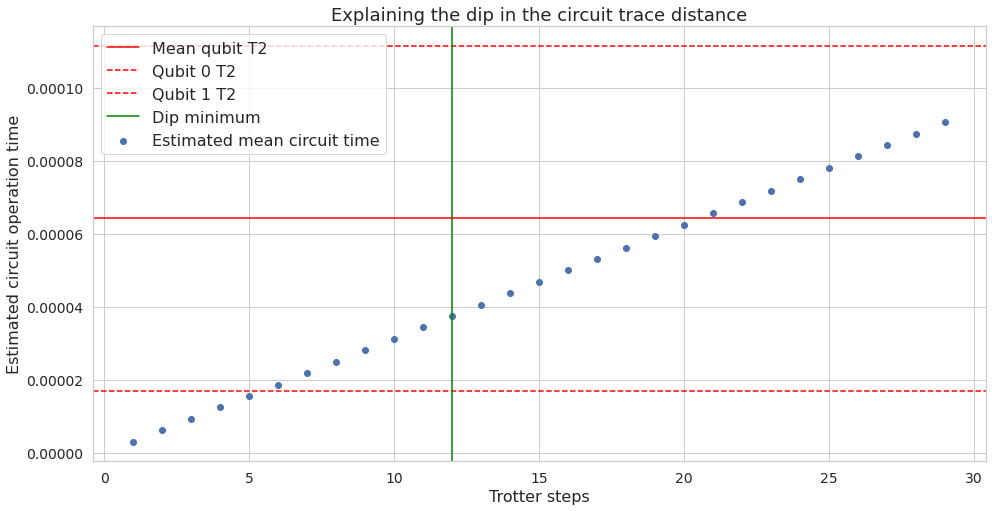

In [48]:
plt.scatter(range(1, len(circuit_data_gc)+1), mean_circuit_times, label="Estimated mean circuit time")
plt.axhline(y=mean_t2, color='red', label='Mean qubit T2')
plt.axhline(y=qubit0_t2, color='red', linestyle='dashed', label="Qubit 0 T2")
plt.axhline(y=qubit1_t2, color='red', linestyle='dashed', label="Qubit 1 T2")
plt.axvline(x=12, color='green', label="Dip minimum")
plt.xlabel("Trotter steps", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Estimated circuit operation time", fontsize=16)
plt.legend(fontsize=16)
plt.title("Explaining the dip in the circuit trace distance", fontsize=18);
plt.savefig("dip.pdf")


This isn't a perfect assessment, but we can see that somewhere in this range this is where we surpass the mean coherence time.

With respect to the Jordan Wigner version - we know that the number of CNOTs is roughly double, while the depth is about 11% more. So we expect that this would fare worse overall, but let's see.

In [49]:
qubit2_t2 = 141.43954844693835e-6
qubit3_t2 = 120.90398756232938e-6
mean_t2_jw = (qubit0_t2 + qubit1_t2 + qubit2_t2 + qubit3_t2)/4

In [50]:
properties.gates[-8:-2]

[namespace(qubits=[0, 1],
           gate='cx',
           parameters=[Nduv(datetime.datetime(2020, 8, 9, 6, 15, 13, tzinfo=tzutc()), gate_error, , 0.0090516055381267),
                       Nduv(datetime.datetime(2020, 8, 9, 6, 38, 5, tzinfo=tzutc()), gate_length, ns, 348.4444444444444)],
           name='cx0_1'),
 namespace(qubits=[1, 0],
           gate='cx',
           parameters=[Nduv(datetime.datetime(2020, 8, 9, 6, 15, 13, tzinfo=tzutc()), gate_error, , 0.0090516055381267),
                       Nduv(datetime.datetime(2020, 8, 9, 6, 38, 5, tzinfo=tzutc()), gate_length, ns, 384)],
           name='cx1_0'),
 namespace(qubits=[1, 2],
           gate='cx',
           parameters=[Nduv(datetime.datetime(2020, 8, 9, 6, 29, 30, tzinfo=tzutc()), gate_error, , 0.008573434377345951),
                       Nduv(datetime.datetime(2020, 8, 9, 6, 38, 5, tzinfo=tzutc()), gate_length, ns, 227.55555555555554)],
           name='cx1_2'),
 namespace(qubits=[1, 3],
           gate='cx',
         

In [51]:
mean_cnot_jw = (348.4444444444444e-9 + 384e-9 + 227.555555555e-9 + 497.7777e-9 + 263.1111e-9 + 462.2222e-9)/6

In [52]:
circuit_data_jw = [[1, 39.0, 19.0, 36.0],
                    [2, 73.0, 31.0, 57.0],
                    [3, 107.0, 43.0, 78.0],
                    [4, 141.0, 55.0, 99.0],
                    [5, 175.0, 67.0, 120.0],
                    [6, 209.0, 79.0, 141.0],
                    [7, 243.0, 91.0, 162.0],
                    [8, 277.0, 103.0, 183.0],
                    [9, 311.0, 115.0, 204.0],
                    [10, 345.0, 127.0, 225.0],
                    [11, 379.0, 139.0, 246.0],
                    [12, 413.0, 151.0, 267.0],
                    [13, 447.0, 163.0, 288.0],
                    [14, 481.0, 175.0, 309.0],
                    [15, 515.0, 187.0, 330.0],
                    [16, 549.0, 199.0, 351.0],
                    [17, 583.0, 211.0, 372.0],
                    [18, 617.0, 223.0, 393.0],
                    [19, 651.0, 235.0, 414.0],
                    [20, 685.0, 247.0, 435.0],
                    [21, 719.0, 259.0, 456.0],
                    [22, 753.0, 271.0, 477.0],
                    [23, 787.0, 283.0, 498.0],
                    [24, 821.0, 295.0, 519.0],
                    [25, 855.0, 307.0, 540.0],
                    [26, 889.0, 319.0, 561.0],
                    [27, 923.0, 331.0, 582.0],
                    [28, 957.0, 343.0, 603.0],
                    [29, 991.0, 355.0, 624.0]]


In [53]:
# Compute the mean circuit time
mean_circuit_times_jw = [] 
for idx in range(len(circuit_data_jw)):
    # Average number of gates per layer
    cnot_only = circuit_data_jw[idx][2]/circuit_data_jw[idx][3]
    sq_only = 1 - cnot_only
    mean_circuit_time = circuit_data_jw[idx][3]*(cnot_only*mean_cnot_jw + sq_only*u3_length)
    print(f"Steps:{circuit_data_jw[idx][0]}\t Estimated gate time={mean_circuit_time}")
    mean_circuit_times_jw.append(mean_circuit_time)

Steps:1	 Estimated gate time=8.122071833331575e-06
Steps:2	 Estimated gate time=1.3128292833330466e-05
Steps:3	 Estimated gate time=1.8134513833329356e-05
Steps:4	 Estimated gate time=2.3140734833328245e-05
Steps:5	 Estimated gate time=2.8146955833327135e-05
Steps:6	 Estimated gate time=3.3153176833326024e-05
Steps:7	 Estimated gate time=3.8159397833324916e-05
Steps:8	 Estimated gate time=4.31656188333238e-05
Steps:9	 Estimated gate time=4.8171839833322694e-05
Steps:10	 Estimated gate time=5.317806083332158e-05
Steps:11	 Estimated gate time=5.818428183332047e-05
Steps:12	 Estimated gate time=6.319050283331937e-05
Steps:13	 Estimated gate time=6.819672383331826e-05
Steps:14	 Estimated gate time=7.320294483331716e-05
Steps:15	 Estimated gate time=7.820916583331602e-05
Steps:16	 Estimated gate time=8.321538683331491e-05
Steps:17	 Estimated gate time=8.822160783331383e-05
Steps:18	 Estimated gate time=9.32278288333127e-05
Steps:19	 Estimated gate time=9.823404983331159e-05
Steps:20	 Estima

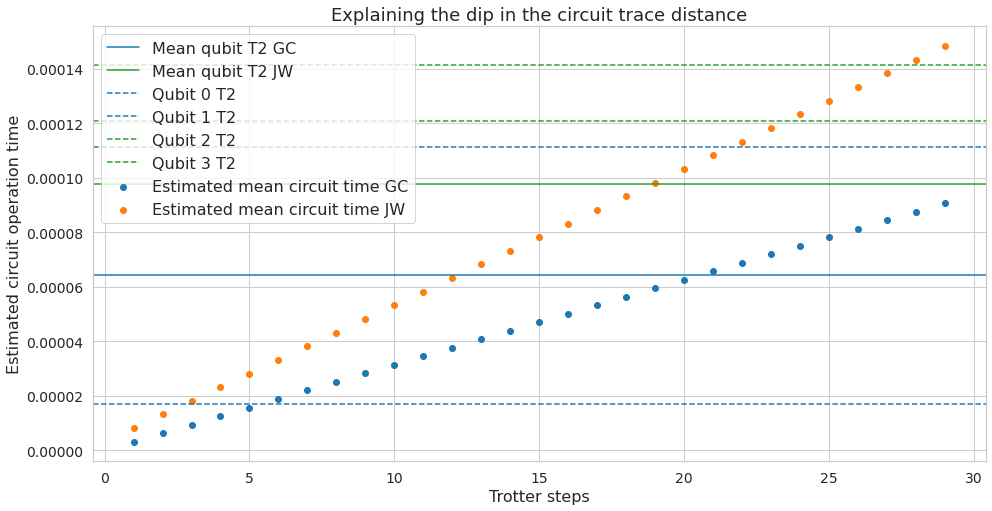

In [54]:
plt.scatter(range(1, len(circuit_data_jw)+1), mean_circuit_times, label="Estimated mean circuit time GC", color='tab:blue')
plt.scatter(range(1, len(circuit_data_jw)+1), mean_circuit_times_jw, label="Estimated mean circuit time JW", color='tab:orange')
plt.axhline(y=mean_t2, color='tab:blue', label='Mean qubit T2 GC')
plt.axhline(y=mean_t2_jw, color='tab:green', label='Mean qubit T2 JW')
plt.axhline(y=qubit0_t2, color='tab:blue', linestyle='dashed', label="Qubit 0 T2")
plt.axhline(y=qubit1_t2, color='tab:blue', linestyle='dashed', label="Qubit 1 T2")
plt.axhline(y=qubit2_t2, color='tab:green', linestyle='dashed', label="Qubit 2 T2")
plt.axhline(y=qubit3_t2, color='tab:green', linestyle='dashed', label="Qubit 3 T2")
plt.xlabel("Trotter steps", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Estimated circuit operation time", fontsize=16)
plt.legend(fontsize=16)
plt.title("Explaining the dip in the circuit trace distance", fontsize=18);
plt.savefig("dip.pdf")
